1) INSTALL AND IMPORTS + REPRODUCIBILITY

In [1]:
# Cell 1 — Setup
!pip install -q scikit-learn pandas matplotlib xgboost shap

import os, zipfile, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib

SEED = 42
random.seed(SEED); np.random.seed(SEED)
plt.style.use("seaborn-v0_8-whitegrid")



2) UPLOAD DATASET

In [2]:
# Cell 2 — Upload your CSV (or .zip that contains the CSV)
from google.colab import files
uploaded = files.upload()   # choose your file (e.g., lung_cancer.csv or lung_cancer.zip)

# If a zip is uploaded, extract it
for name in uploaded.keys():
    if name.lower().endswith(".zip"):
        with zipfile.ZipFile(name, "r") as z:
            z.extractall("data")
        # try to auto-find csv inside
        for root, dirs, files in os.walk("data"):
            for f in files:
                if f.lower().endswith(".csv"):
                    csv_path = os.path.join(root, f)
                    break
        print("Found CSV inside zip:", csv_path)
    elif name.lower().endswith(".csv"):
        csv_path = name

print("Using:", csv_path)
df = pd.read_csv(csv_path)
df.head(5)


Saving dataset_med.zip to dataset_med.zip
Found CSV inside zip: data/dataset_med.csv
Using: data/dataset_med.csv


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


3) QUICK EDA AND SANITY CHECKS

In [3]:
# Cell 3 — EDA
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample rows:")
display(df.head())

print("\nMissing values (%):")
print((df.isna().mean()*100).round(2))

# If survived is string, normalize
if "survived" in df.columns:
    df['survived'] = df['survived'].astype(str).str.strip().str.lower().map({'yes':1,'y':1,'1':1,'true':1,'no':0,'n':0,'0':0,'false':0})
    print("\nSurvived value counts:\n", df['survived'].value_counts(dropna=False))


Shape: (890000, 17)

Columns: ['id', 'age', 'gender', 'country', 'diagnosis_date', 'cancer_stage', 'family_history', 'smoking_status', 'bmi', 'cholesterol_level', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type', 'end_treatment_date', 'survived']

Sample rows:


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0



Missing values (%):
id                    0.0
age                   0.0
gender                0.0
country               0.0
diagnosis_date        0.0
cancer_stage          0.0
family_history        0.0
smoking_status        0.0
bmi                   0.0
cholesterol_level     0.0
hypertension          0.0
asthma                0.0
cirrhosis             0.0
other_cancer          0.0
treatment_type        0.0
end_treatment_date    0.0
survived              0.0
dtype: float64

Survived value counts:
 survived
0    693996
1    196004
Name: count, dtype: int64


4) FEATURING DATES,DURATION,BASIC CLEANING

In [4]:
# Cell 4 — Feature engineering
def parse_date(col):
    # attempt several common formats
    return pd.to_datetime(col, errors='coerce', infer_datetime_format=True)

# Columns from your spec:
# diagnosis_date, end_treatment_date, age, gender, country, cancer_stage,
# family_history, smoking_status, bmi, cholesterol_level, hypertension,
# asthma, cirrhosis, other_cancer, treatment_type, survived

# parse dates:
if 'diagnosis_date' in df.columns:
    df['diagnosis_date'] = parse_date(df['diagnosis_date'])
if 'end_treatment_date' in df.columns:
    df['end_treatment_date'] = parse_date(df['end_treatment_date'])

# create duration (days) between diagnosis and end_treatment_date if both exist:
if 'diagnosis_date' in df.columns and 'end_treatment_date' in df.columns:
    df['treatment_duration_days'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days
    # sometimes end_treatment_date is death date; negative/very large durations flag
    df.loc[df['treatment_duration_days'] < 0, 'treatment_duration_days'] = np.nan

# Normalize text categories: strip and lower
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# Convert boolean-like columns to 'yes'/'no' normalized if present
bool_like = ['family_history','hypertension','asthma','cirrhosis','other_cancer']
for c in bool_like:
    if c in df.columns:
        df[c] = df[c].astype(str).str.lower().replace({'true':'yes','false':'no','1':'yes','0':'no'})

# check new columns
print("After FE columns:", df.columns.tolist())
display(df[['diagnosis_date','end_treatment_date','treatment_duration_days']].head())


/tmp/ipython-input-3868283661.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(col, errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-3868283661.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(col, errors='coerce', infer_datetime_format=True)


After FE columns: ['id', 'age', 'gender', 'country', 'diagnosis_date', 'cancer_stage', 'family_history', 'smoking_status', 'bmi', 'cholesterol_level', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type', 'end_treatment_date', 'survived', 'treatment_duration_days']


,diagnosis_date,end_treatment_date,treatment_duration_days
0,2016-04-05,2017-09-10,523.0
1,2023-04-20,2024-06-17,424.0
2,2023-04-05,2024-04-09,370.0
3,2016-02-05,2017-04-23,443.0
4,2023-11-29,2025-01-08,406.0


5) CHOOSE TARGET, HANDLE MISSING ROWS

In [5]:
# Cell 5 — Pick target
# If survived exists, use it. Otherwise derive: survived = end_treatment_date exists and patient alive? (not reliable)
if 'survived' in df.columns:
    target_col = 'survived'
else:
    raise ValueError("Target column 'survived' not found. Add it or provide logic to compute it.")

# drop rows without target
df = df[~df[target_col].isna()].copy()
print("Rows after dropping missing target:", df.shape[0])
print(df[target_col].value_counts())

Rows after dropping missing target: 890000
survived
0    693996
1    196004
Name: count, dtype: int64


6) PREPROCESS: SPLIT NUMERIC VS CATEGORICAL, PIPELINE

In [6]:
# Cell 6 — Preprocessing & train/test split (with downsampling for Colab)
drop_cols = ['id','diagnosis_date','end_treatment_date'] if 'id' in df.columns else ['diagnosis_date','end_treatment_date']
features = [c for c in df.columns if c not in drop_cols + [target_col]]

X = df[features].copy()
y = df[target_col].astype(int)

# detect numeric/categorical
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Pipelines
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
], remainder='drop')

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ✅ Downsample training set to 100k rows for Colab safety
if len(X_train) > 100000:
    X_train, _, y_train, _ = train_test_split(
        X_train, y_train, train_size=100000, random_state=SEED, stratify=y_train
    )

print("Train size after downsampling:", X_train.shape)
print("Test size:", X_test.shape)


Numeric cols: ['age', 'bmi', 'cholesterol_level', 'treatment_duration_days']
Categorical cols: ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type']
Train size after downsampling: (100000, 14)
Test size: (178000, 14)


7) TRAIN BASELINE MODELS: LOGISTIC REGRESSION, RANDOM FOREST, XGBOOST

In [7]:
# Cell 7 — Train & compare models (lighter versions)
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, random_state=SEED, class_weight="balanced"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=50, max_depth=10, random_state=SEED, n_jobs=-1, class_weight="balanced"
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=50,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=SEED,
        scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)  # handle imbalance
    )
}

results = {}
for name, clf in models.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
    print("\nTraining:", name)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    print(f"{name} — Acc: {acc:.4f}  AUC: {auc:.4f}")
    results[name] = {"pipe": pipe, "acc": acc, "auc": auc}



Training: LogisticRegression
LogisticRegression — Acc: 0.4981  AUC: 0.4988

Training: RandomForest
RandomForest — Acc: 0.5971  AUC: 0.4997

Training: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:29:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost — Acc: 0.5022  AUC: 0.4969


8) CONFUSION MATRIX + CLASSIFICATION REPORT

Best model: RandomForest {'pipe': Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'cholesterol_level',
                                                   'treatment_duration_days']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strateg

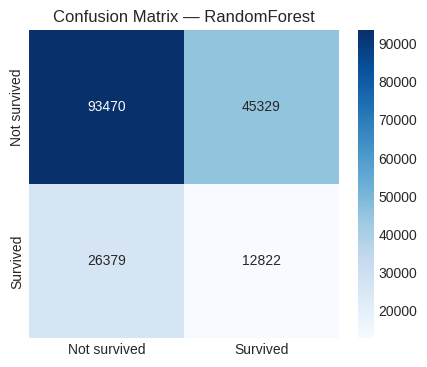

Test accuracy: 0.5971460674157303
Test ROC-AUC: 0.4997475452207411
Saved model -> lung_survival_model.joblib


In [8]:
# Cell 8 — choose best by AUC
best_name = max(results.keys(), key=lambda n: results[n]['auc'])
best_pipe = results[best_name]['pipe']
print("Best model:", best_name, results[best_name])

# Evaluate
pred = best_pipe.predict(X_test)
proba = best_pipe.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, pred, target_names=["Not survived","Survived"]))

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Not survived","Survived"], yticklabels=["Not survived","Survived"], cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}")
plt.show()

print("Test accuracy:", accuracy_score(y_test, pred))
print("Test ROC-AUC:", roc_auc_score(y_test, proba))

# Save model
joblib.dump(best_pipe, "lung_survival_model.joblib")
print("Saved model -> lung_survival_model.joblib")


9) Feature importance / interpretation (for tree models) & SHAP (optional)

In [9]:
# Cell 9 — feature importance if RF/XGB
if best_name in ("RandomForest","XGBoost"):
    num_features = num_cols
    cat_features = best_pipe.named_steps['pre'].named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols).tolist()
    feature_names = num_features + cat_features
    clf = best_pipe.named_steps['clf']
    importances = clf.feature_importances_
    fi = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:20]
    print("Top features:\n", fi)
else:
    print("Feature importance not available for", best_name)


Top features:
 [('treatment_duration_days', np.float64(0.14148768342826915)), ('bmi', np.float64(0.12784584961534165)), ('cholesterol_level', np.float64(0.12545595288756498)), ('age', np.float64(0.11978278408308857)), ('gender_Female', np.float64(0.017615203950089954)), ('asthma_no', np.float64(0.01698193563896649)), ('family_history_no', np.float64(0.01675427873333177)), ('gender_Male', np.float64(0.01629759433847999)), ('smoking_status_Former Smoker', np.float64(0.016203466326808857)), ('family_history_yes', np.float64(0.01613114785679779)), ('cancer_stage_Stage II', np.float64(0.015638499031741297)), ('asthma_yes', np.float64(0.015575132656384423)), ('smoking_status_Current Smoker', np.float64(0.015482253431915853)), ('smoking_status_Passive Smoker', np.float64(0.015365845924085514)), ('smoking_status_Never Smoked', np.float64(0.015203968886073527)), ('cancer_stage_Stage I', np.float64(0.014835659660354869)), ('hypertension_yes', np.float64(0.014779155725622028)), ('cirrhosis_yes', 

10) PREDICT ON A NEW PATIENT

In [10]:
# Cell 10 — Example prediction on new patient
model = joblib.load("lung_survival_model.joblib")

example = {
    "age": 65,
    "gender": "male",
    "country": "India",
    "cancer_stage": "Stage IV",
    "family_history": "no",
    "smoking_status": "current smoker",
    "bmi": 24.5,
    "cholesterol_level": 180,
    "hypertension": "no",
    "asthma": "no",
    "cirrhosis": "no",
    "other_cancer": "no",
    "treatment_type": "chemotherapy",
    "treatment_duration_days": 365  # provide value to match features
}

x_new = pd.DataFrame([example])[features]  # ensure same ordering
prob = model.predict_proba(x_new)[0,1]
print(f"Predicted survival probability: {prob:.3f} -> {'Survived' if prob>=0.5 else 'Not survived'}")


Predicted survival probability: 0.499 -> Not survived
